## Classification

In [2]:
import pandas as pd
import numpy as np
import re
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from stop_words import get_stop_words
import nltk
from nltk import wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.corpus import wordnet

import string
from string import punctuation
string.punctuation += '-—«»—…–“”'

import pkg_resources
from symspellpy.symspellpy import SymSpell

from sklearn.model_selection import train_test_split
import sklearn
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM,Bidirectional,Dense,Embedding,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

import keras
from keras.preprocessing import sequence

import gensim
from gensim.models import FastText

In [4]:
data = pd.read_csv('Lemmas_last.csv')

In [5]:
data

,Product,Consumer complaint narrative,lemmas
0,"Money transfer, virtual currency, or money ser...",Coin base refuses to change my email address t...,coin base refuse change email address longer a...
1,Credit card or prepaid card,Capital One Bank has not resolved or attempted...,capital one bank resolve attempt resolve issue...
2,Checking or savings account,On XX/XX/2018 I traveled to XXXX. I remained i...,travel remain absence us confirm flight reserv...
3,"Money transfer, virtual currency, or money ser...","Hi, On XXXX XXXX fraud transactions ( XXXX tra...",fraud transaction transfer happen bank check a...
4,Vehicle loan or lease,We pay extra every month on a car loan that we...,pay extra every month car loan obtain notice e...
...,...,...,...
94810,Checking or savings account,"I opened an account with BOA, which I had in g...",open account boa good standing several year ne...
94811,Mortgage,my wife had 3 XXXX XXXX in 2 years. i got lai...,wife year get lay lot work get lay get letter ...
94812,Vehicle loan or lease,This complaint is related to GM Financial XXXX...,complaint relate pm financial address tom fina...
94813,Mortgage,My situation dates back many years to dealings...,situation date back many year dealing region b...


Перемешаем данные.

In [43]:
data = data.sample(frac=1).reset_index(drop='True')

In [44]:
data

,Product,Consumer complaint narrative,lemmas
0,"Credit reporting, credit repair services, or o...",I am making a final goodwill attempt to have X...,make final goodwill attempt trans union clear ...
1,Vehicle loan or lease,"I, Am writing this letter for a family member ...",write letter family member speak english estim...
2,Checking or savings account,I have bill service at BBT and month after the...,bill service month pay bill early schedule pay...
3,"Credit reporting, credit repair services, or o...",I have been disputing this debt inaccuracy for...,dispute debt inaccuracy month late letter expe...
4,Student loan,My bank account was drafted by a third party l...,bank account draft third party loan forgivenes...
...,...,...,...
94810,Mortgage,"During my mortgage transfer, the gaining loan ...",mortgage transfer gaining loan service poor cu...
94811,Credit card or prepaid card,XX/XX/XXXX Bank of America # XXXX. My income w...,bank america income decrease social security a...
94812,Mortgage,WIFE OMITTED FROM MORTGAGE : 1. All through th...,wife omit mortgage application process basis m...
94813,Checking or savings account,I have a checkin account with Santander Bank. ...,checking account santa bank account open regul...


Выберем столбец с данными и столбец с метками.

In [155]:
X = data['lemmas']
y = data['Product']
print(X.shape)
print(y.shape)

(94815,)
(94815,)


Подсчитаем максимальную длину текста.

In [156]:
max_doc_len = max([len(x.split(" ")) for x in X])

In [157]:
max_doc_len

438

Зададим параметры токенайзера.

In [158]:
tokenizer = Tokenizer(5000)

Векторизуем тексты.

In [159]:
tokenizer.fit_on_texts(X)
X_train_seq = tokenizer.texts_to_sequences(X)
X_train_seq = pad_sequences(X_train_seq, maxlen = max_doc_len, padding='post')

Закодируем метки классов.

In [160]:
en = LabelEncoder()
y_en = en.fit_transform(y)
print(np.unique(y_en, return_counts = True))

y_en = to_categorical(y_en, num_classes = 9)
print(y_en)
print(y_en.shape)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([10535, 10535, 10535, 10535, 10535, 10535, 10535, 10535, 10535],
      dtype=int64))
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
(94815, 9)


In [161]:
en.classes_

array(['Checking or savings account', 'Credit card or prepaid card',
       'Credit reporting, credit repair services, or other personal consumer reports',
       'Debt collection',
       'Money transfer, virtual currency, or money service', 'Mortgage',
       'Payday loan, title loan, or personal loan', 'Student loan',
       'Vehicle loan or lease'], dtype=object)

Создадим выборки для тренировки и обучения.

In [187]:
X_train, X_test, y_train, y_test = train_test_split(X_train_seq, y_en, test_size=0.25, stratify = y_en)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(71111, 438)
(71111, 9)
(23704, 438)
(23704, 9)


In [188]:
print(X_train[100])

[  59 1097   68  412  104  137  488  235   13    4   13   68  578  165
   28  312  192    1   78  392   47   68  312  578  165  459  404  312
 1373    9 3787  286 2767  224  769   23  370  270   42   57 1349  215
 1239   92    9 3328 3340  412  380  224 3553   23   50 3340  286 2098
 1006    4   13   65 1923 1483 1005   28  312  286    7 1127  224 3553
   23  334  388  387  843  341  358  104  431   23  866  412  104  137
   68  137  412 2431  380   23 1188   13  388  387 1038  578  165   33
   73   30   23 1038  187   33   65  412 1341 2239  137 2024  973   23
  578  165   28  224 3553   23  578  165  808   23 3328 3340  423 1038
   23  400  286  388  387 1038 1098  224 3553   23  345 3328 3340   56
  412  597 2133  104  291 1435   23  172   68   68  412  185   68  291
  109  608  160   23   68  176   23 4230  574    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [189]:
word_index = tokenizer.word_index
print(len(word_index))

20862


Обучим модель FastText на нашем корпусе и создадим матрицу с векторными представлениями слов.

In [165]:
lemmas = data.lemmas.tolist()
lemmas = [i.split() for i in lemmas]

In [46]:
model = FastText(size=300, window=5, min_count=1, workers=2)

In [ ]:
model.build_vocab(sentences=lemmas)

In [ ]:
model.train(sentences=lemmas, total_examples=len(lemmas), epochs=10) 

In [ ]:
model.save("fasttext.model")

In [3]:
model = gensim.models.FastText.load("fasttext.model")

In [29]:
vector = model.wv['account']

In [30]:
vector

array([-1.74757302e+00, -2.93763638e-01, -1.37813106e-01,  2.40931675e-01,
        5.10363221e-01,  1.10257959e+00,  1.11384976e+00, -3.09194833e-01,
        1.62597525e+00,  3.87565792e-02, -7.82575130e-01,  9.38576400e-01,
       -1.05091870e+00,  1.30364192e+00,  7.88448393e-01,  5.93373358e-01,
        1.46644592e+00,  9.48265970e-01, -6.84381545e-01,  4.44967568e-01,
       -2.27114990e-01,  1.51321340e+00, -2.96204865e-01, -1.67760566e-01,
       -1.86732128e-01, -2.82165438e-01, -8.68667006e-01,  1.20634413e+00,
        6.90004706e-01, -1.18558788e+00,  1.54036507e-01,  1.00317024e-01,
        3.34764928e-01, -2.61712186e-02,  9.20846701e-01, -1.92411268e+00,
       -8.57169211e-01, -1.76842324e-02,  6.76416457e-01,  3.05412128e-03,
        8.44662189e-01,  1.03904319e+00,  1.11117782e-02,  3.05366158e-01,
       -4.13399249e-01, -4.36383814e-01,  9.03074443e-01,  1.01999962e+00,
       -7.79607296e-01,  1.29008666e-01,  1.14320433e+00, -5.06016612e-01,
        3.91932517e-01, -

In [25]:
sims = model.wv.most_similar('account', topn=5)

In [26]:
sims

[('accountancy', 0.6540124416351318),
 ('unaccounted', 0.6372307538986206),
 ('accountant', 0.6363760828971863),
 ('rechecking', 0.6053496599197388),
 ('recount', 0.6016854047775269)]

In [22]:
embeddings_index = {w: vec for w, vec in zip(model.wv.index2word, model.wv.vectors)}

In [23]:
len(embeddings_index)

20862

In [24]:
EMBEDDING_DIM = 300
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [25]:
embedding_matrix.shape

(20863, 300)

In [26]:
[(k,v) for k,v in word_index.items() if v==2]

[('payment', 2)]

In [27]:
embedding_matrix[2]

array([ 7.31539011e-01, -7.82936335e-01,  1.06916523e+00, -8.77592087e-01,
       -4.30221885e-01,  7.35350966e-01, -5.70138574e-01, -4.13183533e-02,
       -3.54225606e-01, -1.49564905e-04,  8.05403233e-01,  3.10909450e-01,
        2.74397492e-01,  3.23519930e-02,  1.74915612e+00, -1.10918248e+00,
       -2.45208359e+00,  3.03215533e-01,  4.47574943e-01,  3.13779205e-01,
       -4.64198649e-01, -1.40496993e+00, -4.19258505e-01,  9.26579654e-01,
       -1.09350383e+00,  5.65705299e-01,  7.12000966e-01,  1.22846699e+00,
        7.33553708e-01,  1.72121137e-01,  9.37234402e-01,  1.06250060e+00,
        7.33047009e-01,  9.85433310e-02,  3.14794332e-01, -1.82026207e+00,
        8.25520337e-01, -8.76159072e-01,  3.52541178e-01,  1.75187206e+00,
       -3.79877210e-01,  4.34083007e-02, -1.16799176e+00,  1.25821388e+00,
        8.70543998e-03, -1.35870075e+00, -2.57674873e-01,  7.86611736e-01,
        6.49223447e-01, -8.84545922e-01,  1.21828938e+00,  1.34859288e+00,
        2.47813687e-01,  

Зададим параметры модели.

In [190]:
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=max_doc_len,
                            trainable=True))
model.add(Bidirectional(LSTM(100, recurrent_dropout=0.2, dropout=0.2)))
model.add(Dense(9, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [191]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 438, 300)          6258900   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 200)               320800    
_________________________________________________________________
dense_8 (Dense)              (None, 9)                 1809      
Total params: 6,581,509
Trainable params: 6,581,509
Non-trainable params: 0
_________________________________________________________________


In [192]:
history = model.fit(X_train, y_train, batch_size=30, epochs=6, validation_data=(X_test, y_test))

Epoch 1/6
2371/2371 [==============================] - 12249s 5s/step - loss: 0.7198 - accuracy: 0.7698 - val_loss: 0.6066 - val_accuracy: 0.8056
Epoch 2/6
2371/2371 [==============================] - 12478s 5s/step - loss: 0.5641 - accuracy: 0.8183 - val_loss: 0.5817 - val_accuracy: 0.8129
Epoch 3/6
2371/2371 [==============================] - 13044s 6s/step - loss: 0.5096 - accuracy: 0.8348 - val_loss: 0.5660 - val_accuracy: 0.8194
Epoch 4/6
2371/2371 [==============================] - 14343s 6s/step - loss: 0.4743 - accuracy: 0.8452 - val_loss: 0.5641 - val_accuracy: 0.8210
Epoch 5/6
2371/2371 [==============================] - 13233s 6s/step - loss: 0.4480 - accuracy: 0.8551 - val_loss: 0.5643 - val_accuracy: 0.8244
Epoch 6/6
2371/2371 [==============================] - 13010s 5s/step - loss: 0.4221 - accuracy: 0.8625 - val_loss: 0.5711 - val_accuracy: 0.8239


In [193]:
model.save('model_keras.h5')

In [243]:
model = keras.models.load_model('model_keras.h5')

Посмотрим на графики Accuracy и Loss.

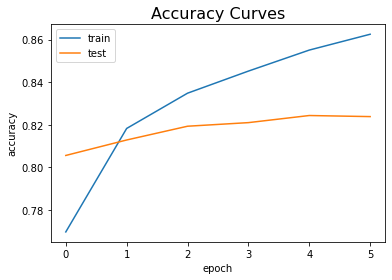

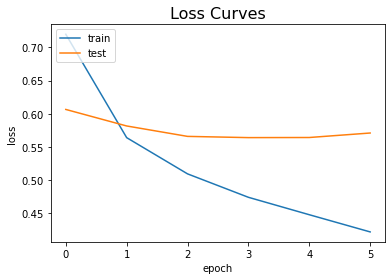

In [195]:
# График Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.title('Accuracy Curves', fontsize=16)
plt.show()

# График Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.title('Loss Curves', fontsize=16)
plt.show()

Посмотрим на метрики и матрицу ошибок.

In [196]:
predicted=model.predict(X_test)
predicted

array([[1.14109311e-02, 1.91162035e-01, 2.14343816e-02, ...,
        1.46462962e-01, 1.05339311e-01, 2.13220149e-01],
       [8.14227024e-05, 1.18845826e-04, 1.62274664e-04, ...,
        9.76775348e-01, 5.02148410e-04, 4.12248861e-04],
       [1.24139152e-03, 9.94152367e-01, 1.97850377e-03, ...,
        5.30822901e-04, 1.49170701e-05, 1.21874400e-04],
       ...,
       [7.37208407e-04, 5.94015182e-05, 1.82251970e-03, ...,
        1.04377267e-03, 3.38540995e-05, 1.21568366e-04],
       [8.50091863e-04, 8.63076281e-03, 9.58981454e-01, ...,
        2.12458838e-02, 7.96696695e-04, 5.39527368e-03],
       [1.91068739e-01, 1.67553301e-03, 3.88485467e-04, ...,
        3.28229927e-03, 7.09256637e-05, 7.14846849e-02]], dtype=float32)

In [197]:
print(classification_report(y_test, predicted.round(), target_names=en.classes_))

                                                                              precision    recall  f1-score   support

                                                 Checking or savings account       0.81      0.82      0.81      2633
                                                 Credit card or prepaid card       0.83      0.78      0.80      2634
Credit reporting, credit repair services, or other personal consumer reports       0.82      0.70      0.76      2633
                                                             Debt collection       0.79      0.78      0.79      2634
                          Money transfer, virtual currency, or money service       0.89      0.80      0.84      2634
                                                                    Mortgage       0.91      0.93      0.92      2634
                                   Payday loan, title loan, or personal loan       0.81      0.71      0.76      2634
                                                       

H:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


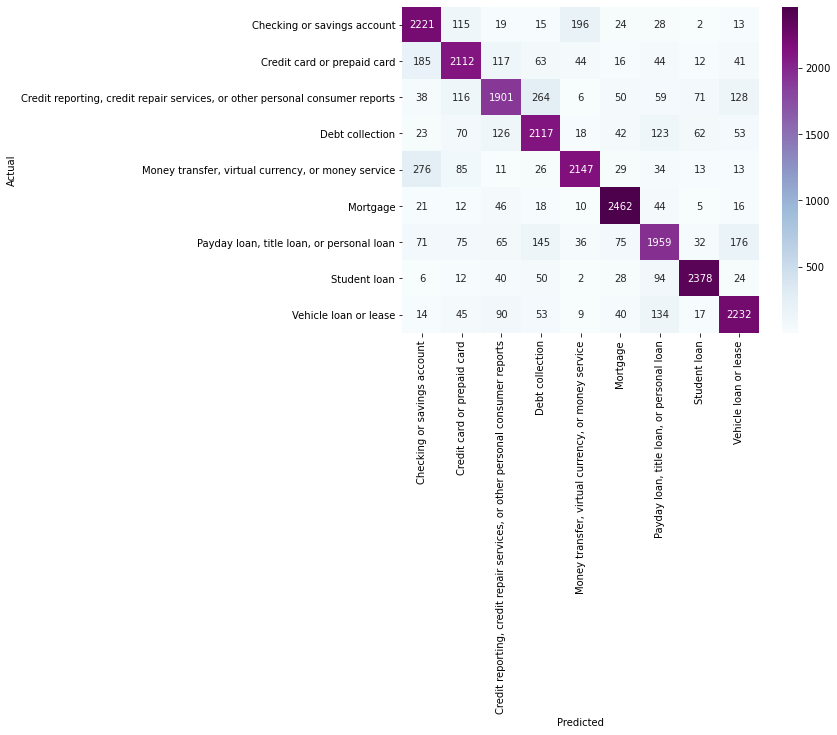

In [198]:
conf_mat = confusion_matrix(y_test.argmax(axis=1), predicted.argmax(axis=1))
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="BuPu", xticklabels=en.classes_, yticklabels=en.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Протестируем модель на новом сообщении.

In [199]:
contraction_dict = {"ain't": "are not", " aint ": " are not ", "aren't": "are not", " cant ": " cannot ", "can't": "cannot", "'cause": "because", ' chk ': ' check ', "could've": "could have", "couldn't": "could not", "couldnt": "could not", "'d ": " would ", "didnt": "did not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "dont": "do not", "doesnt": "does not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have", " iVe ": "I have", "Ive": "I have", " im ": " I am ", " Im ": " I am ", "I'm": "I am", "I've": "I have", "Id": "I would", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have", "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is", "'ll": " will ", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have", "mightn't": "might not", "mightn't've": "might not have", ' mths ': ' months ', "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have", "n't": " not ", "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "'re": " are ", ' rcvd ': ' received ', "'s": " ", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have", "so's": "so as", "this's": "this is", "that'd": "that would", "that'd've": "that would have", "thats": "that is", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is", "they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "theyre": "they are", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", "'ve": " have ", " yrs ": " years "}

In [200]:
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re
contractions, contractions_re = _get_contractions(contraction_dict)
def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

In [201]:
def remove_url(text):
    text_without_url = re.sub(r'http[s]?://\S+', ' ', text)
    text_without_url = re.sub(r'http[s]? : //\S+', ' ', text_without_url)
    text_without_url = re.sub(r'http[s]? :', ' ', text_without_url)
    text_without_url = re.sub(r'http[s]?', ' ', text_without_url)
    text_without_url = re.sub(r'//www\.\S+', ' ', text_without_url) 
    text_without_url = re.sub(r'www\.\S+', '', text_without_url)
    text_without_url = re.sub(r'\( i+ \)', '', text_without_url) 
    text_without_url = re.sub(r'\S+\.com', ' ', text_without_url)
    text_without_url = re.sub(r'\S+\.gov', ' ', text_without_url)
    text_without_url = re.sub(r'[\w\.-]+@[\w\.-]+(\.[\w]+)+', ' ', text_without_url)
    text_without_url = re.sub(r'\S+\.pdf', ' ', text_without_url)
    text_without_url = re.sub(r'\S+\.png', ' ', text_without_url)
    return(text_without_url)

In [202]:
def bad_symb_replace(text):
    REPLACE_BY_SPACE_RE = re.compile('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~-—«»—…–“”0-9]')
    clean_text = REPLACE_BY_SPACE_RE.sub(' ',  text)
    clean_text = re.sub("XX+"," ", clean_text)
    clean_text = re.sub("[X/]+", " ", clean_text)
    clean_text = clean_text.lower()
    clean_text = clean_text.replace("\n", " ").replace("\n\n", " ").replace("   ", " ").replace("   ", " ").replace("  ", ' ')
    return clean_text

In [203]:
sym_spell = SymSpell(max_dictionary_edit_distance=1, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

True

In [204]:
def correct(text):
    cleaned_text = sym_spell.word_segmentation(text).corrected_string
    return cleaned_text

In [205]:
stop_words = list(get_stop_words('en'))        
nltk_words = list(stopwords.words('english'))
stop_words.extend(nltk_words)
stop_words = set(stop_words)

In [206]:
stop_words.update(['would', 'hello', 'hi', 'dear', 'mines', 'mr', 'mrs', 'miss', 'ms', 'sir', 'sirs', 'madam', 'please', 'etc', 'xxxx', 'xx', 'x', 'xxx', 'st', 'nd', 'rd', 'th', 'http', 'www', 'com', 'a'])

In [207]:
def preprocess_tokenize(text):
    clean_words = wordpunct_tokenize(text)
    return clean_words

In [208]:
tag_dict = {
    "N": wordnet.NOUN,
    "V": wordnet.VERB,
    "J": wordnet.ADJ,
    "R": wordnet.ADV
}

In [209]:
def extract_wnpostag_from_postag(tag):
    return tag_dict.get(tag[0].upper(), None)

def lemmatize_tupla_word_postag(tupla):
    tag = extract_wnpostag_from_postag(tupla[1])    
    return lemmatizer.lemmatize(tupla[0], tag) if tag is not None else tupla[0]

In [210]:
def msg_lemmatization(message):
    message = replace_contractions(message)
    message = remove_url(message)
    message = bad_symb_replace(message)
    message = correct(message)
    message = preprocess_tokenize(message)
    tagged_words = nltk.pos_tag(message)
    lemmas = [lemmatize_tupla_word_postag(word) for word in tagged_words]
    lemmas = [word for word in lemmas if word not in stop_words]
    lemmas = " ".join(message)
    lemmas = lemmas.replace(' well fargo ', ' wells fargo ')
    return [lemmas]

In [211]:
new_message_input = """I applied for credit with Synchrony Bank XXXX FL and was turn down because their system said my credit score is too low [ XXXX ] this is not correct my score is XXXX XXXX and XXXX XXXX I feel this is Discrimination"""

In [212]:
print(new_message_input)

I applied for credit with Synchrony Bank XXXX FL and was turn down because their system said my credit score is too low [ XXXX ] this is not correct my score is XXXX XXXX and XXXX XXXX I feel this is Discrimination


In [213]:
new_message = msg_lemmatization(new_message_input)
new_message_sequences = tokenizer.texts_to_sequences(new_message)
new_message_data = pad_sequences(new_message_sequences, maxlen=max_doc_len, padding='post')
pred = model.predict(new_message_data)
print("\nPredicted label: {}".format(en.classes_[np.argmax(pred)]))


Predicted label: Credit card or prepaid card


In [214]:
new_message_input2 = """My mortgage is with BB & T Bank, recently I have been investigating ways to pay down my mortgage faster and I came across Biweekly Mortgage Calculator on BB & T 's website. It's a nice, easy to use calculator that you plug in your interest rate, mortgage amount, mortgage term, and payment type and it calculates your accelerated bi-weekly payment for you and shows you how much quicker you can pay down your loan. Ours figured out to pay off a 30 year mortgage in 26.4 years ... quite a savings! I called BB & T 's customer service number to inquire how I get set up on this payment plan. I was told they do not offer that type of payment plan, but I could send in my payments bi-weekly but it would not be applied until the full amount was received. ( the money would sit in a "" holding account '' until the full payment amount was collected ). I ended up calling back a few days later thinking the rep I was talking to didn't understand what I wanted to do or was not knowledgeable of this program. I got the SAME ANSWER! I then asked for the corporate BB & T office number where I could speak to someone that was knowledgeable of this product. After 3 days I received a phone call back from a corporate manager stating they do not offer this product, and they were "" checking into why this is on their website ''. She stated they do have a few customers that make bi-weekly payments, but they no longer offer this service. I don't understand how they can have this active link on their website under their Financial Planning Center tab to mislead customers when all they say is "" I'm sorry, I know you're upset about this '' Sounds like false advertising to me!"""

In [215]:
print(new_message_input2)

My mortgage is with BB & T Bank, recently I have been investigating ways to pay down my mortgage faster and I came across Biweekly Mortgage Calculator on BB & T 's website. It's a nice, easy to use calculator that you plug in your interest rate, mortgage amount, mortgage term, and payment type and it calculates your accelerated bi-weekly payment for you and shows you how much quicker you can pay down your loan. Ours figured out to pay off a 30 year mortgage in 26.4 years ... quite a savings! I called BB & T 's customer service number to inquire how I get set up on this payment plan. I was told they do not offer that type of payment plan, but I could send in my payments bi-weekly but it would not be applied until the full amount was received. ( the money would sit in a "" holding account '' until the full payment amount was collected ). I ended up calling back a few days later thinking the rep I was talking to didn't understand what I wanted to do or was not knowledgeable of this progra

In [216]:
new_message = msg_lemmatization(new_message_input2)
new_message_sequences = tokenizer.texts_to_sequences(new_message)
new_message_data = pad_sequences(new_message_sequences, maxlen=max_doc_len, padding='post')
pred = model.predict(new_message_data)
print("\nPredicted label: {}".format(en.classes_[np.argmax(pred)]))


Predicted label: Mortgage


In [227]:
new_message_input3 = """I 'm XXXX now and I 'm trying to get my free credit report and I keep getting my information does n't match my record?"""

In [228]:
print(new_message_input3)

I 'm XXXX now and I 'm trying to get my free credit report and I keep getting my information does n't match my record?


In [229]:
new_message = msg_lemmatization(new_message_input3)
new_message_sequences = tokenizer.texts_to_sequences(new_message)
new_message_data = pad_sequences(new_message_sequences, maxlen=max_doc_len, padding='post')
pred = model.predict(new_message_data)
print("\nPredicted label: {}".format(en.classes_[np.argmax(pred)]))


Predicted label: Credit reporting, credit repair services, or other personal consumer reports


In [220]:
index = 1
x_test = np.array([data.iloc[index, 1]])
x_label = np.array([data.iloc[index, 0]])
x_test_sequences = tokenizer.texts_to_sequences(x_test)
x_test_data = pad_sequences(x_test_sequences, maxlen=max_doc_len, padding='post')
pred = model.predict(x_test_data)
print("\nNarrative: {} \n\nActual label: {} \n\nPredicted label: {}".format(x_test[0], 
                                                                            x_label[0], 
                                                                            en.classes_[np.argmax(pred)]))


Narrative: I, Am writing this letter for a family member who doesn't speak English. 

On XX/XX/2018 estimated cost {$55.00} I Six months ago helped a friend purchase a car from XXXX dealer On XXXX XXXX. I am limited of understanding and Speaking English, but with my limited English I was assured my name would be taken off the car and placed in my friends name. On XX/XX/XXXX we went to the dealers and I took a translator, since they could not provide me with one the first time. I was informed my name could only be taken off if truck was traded in and a new car was purchased. My friend and his cosigner agreed to this solution. I left truck at dealer with keys with the intention that issue was taken care of. The next day my friend showed up at work with the car he was purchasing from dealer, so I went to dealer that after noon at XXXX XXXX. to sign paper work and received copies that it was out of my name and had no worries everything was taken care of. It is now XX/XX/2018 and I receive

In [242]:
for i in range(10):
    x_test = np.array([data.iloc[i, 1]])
    x_label = np.array([data.iloc[i, 0]])
    x_test_sequences = tokenizer.texts_to_sequences(x_test)
    x_test_data = pad_sequences(x_test_sequences, maxlen=max_doc_len, padding='post')
    pred = model.predict(x_test_data)
    print("\n\nNarrative: {} \n\nActual label: {} \n\nPredicted label: {}\n".format(x_test[0][:700] + '...', 
                                                                            x_label[0], 
                                                                            en.classes_[np.argmax(pred)]))



Narrative: I am making a final goodwill attempt to have XXXX and TransUnion to clear up this matter. They have sent back verified and entirely inaccurate, unverified and represent a serious matter in their credit reporting that they maintain under my social security number. 

Also, please be advised that this is my second time contacting them both about this matter in writing. These companies are in violation of 15 U.S.C 1681. They both have XXXX XXXX reporting as the verification 3rd party, they have no permission to furnish any information on my credit report in the first place. Also note that third party verification systems also known as Pacer.gov, The Fair Credit Reporting Act mentions nothing in ... 

Actual label: Credit reporting, credit repair services, or other personal consumer reports 

Predicted label: Credit reporting, credit repair services, or other personal consumer reports



Narrative: I, Am writing this letter for a family member who doesn't speak English. 

On XX